## Import packge

First of all, we import the packges needed as:

In [7]:
import os
import scipy
import numpy as np
import pandas as pd


import io
import requests

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import cmocean

import seaborn as sns
import pymannkendall as mk

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,7)
%matplotlib inline

## Mackay site 1
We download the data from eReef and change the data format in order to calculate correlation and make line charts.

### Download data


In [2]:
site_lat = -21.129
site_lon = 149.282

In [3]:
selectedDepthIndex = 16 # corresponding to -0.5 m

In [4]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

In [ ]:
 start_date = dt.date(2015, 1, 1)
 end_date = dt.date(2016, 1, 1)
 delta = relativedelta(months=+1)

# # Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
 step = True
 while start_date <= end_date:
    
     # Read individual file from the OpeNDAP server
     netCDF_datestr = str(start_date.year)+'-'+format(start_date.month, '02')
     print('Processing time interval:',netCDF_datestr)
     inputFile = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"+netCDF_datestr+".nc"
     
     start_date += delta    
     nc_data = Dataset(inputFile, 'r')
     ncdata = nc_data.variables
    
     # Get parameters values for each single file
     if step:
         lat = ncdata['latitude'][:].filled(fill_value=0.)
         lon = ncdata['longitude'][:].filled(fill_value=0.)
         times = ncdata['time'][:]
         selectedLatIndex = find_nearest(lat,site_lat)
         selectedLonIndex = find_nearest(lon,site_lon)
         DIN = nc_data.variables['DIN'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         Chl_a_sum = nc_data.variables['Chl_a_sum'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex] 
         PAR = nc_data.variables['PAR'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         TSSM = nc_data.variables['TSSM'][:,selectedLatIndex, selectedLonIndex]
         Secchi =  nc_data.variables['Secchi'][:, selectedLatIndex, selectedLonIndex]
     else:
         days = ncdata['time'][:]
         times = np.hstack((times,days))
         dailyDIN = nc_data.variables['DIN'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         DIN = np.hstack((DIN,dailyDIN))
         dailyChl_a_sum = nc_data.variables['Chl_a_sum'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         Chl_a_sum = np.hstack((Chl_a_sum,dailyChl_a_sum))
         dailyPAR = nc_data.variables['PAR'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         PAR = np.hstack((PAR,dailyPAR))
         dailyTSSM = nc_data.variables['TSSM'][:, selectedLatIndex, selectedLonIndex]
         TSSM = np.hstack((TSSM,dailyTSSM))
         dailySecchi = nc_data.variables['Secchi'][:, selectedLatIndex, selectedLonIndex]
         Secchi = np.hstack((Secchi,dailySecchi))
     step = False


 time = pd.to_datetime(times[:],unit='D',origin=pd.Timestamp('1990-01-01'))

 # Create a pandas dataframe containing the information from all the files
 df = pd.DataFrame(
     data={
         "date": time,
         "DIN": DIN, 
         "Chl_a_sum": Chl_a_sum,
         "PAR": PAR,
         "TSSM": TSSM,
         "Secchi":Secchi
     }
 )

# # Store these informations on a file in case you want to reuse them later on without having to 
# # rerun this cell...
 df.to_csv(
         "Mackay_site1_timeseries.csv",
         columns=["date", 
                  "DIN", 
                  "Chl_a_sum",
                  "PAR",
                  "TSSM",
                  "Secchi",],
         sep=" ",
         index=False,
         header=1,
     )

### Read data and change format


In [8]:
df = pd.read_csv(
        "Mackay_site1_timeseries.csv",
        sep=r"\s+",
        engine="c",
        header=0,
        na_filter=False,
        low_memory=False,
    )
df['date']= pd.to_datetime(df['date'])

In [9]:
df

,date,DIN,Chl_a_sum,PAR,TSSM,Secchi
0,2015-01-01 12:00:00,0.037532,0.102289,0.000962,0.000720,14.272367
1,2015-01-02 12:00:00,0.031354,0.101042,0.000727,0.000720,15.239410
2,2015-01-03 12:00:00,0.031651,0.104185,0.000477,0.000848,13.043923
3,2015-01-04 12:00:00,0.052138,0.159790,0.000740,0.001451,5.045837
4,2015-01-05 12:00:00,0.065477,0.275523,0.000258,0.001790,4.012533
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.030217,0.076674,0.001332,0.000685,15.650508
392,2016-01-28 12:00:00,0.027995,0.073724,0.000829,0.000690,15.065257
393,2016-01-29 12:00:00,0.033285,0.073128,0.000914,0.000681,14.480111
394,2016-01-30 12:00:00,0.055227,0.067358,0.000970,0.000668,14.023984


In [11]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

Chl_a_sum_roll_1 = rolling["Chl_a_sum"]
Chl_a_sum_1 = df["Chl_a_sum"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "Chl_a_sum_1": Chl_a_sum_1,
                "Chl_a_sum_roll_1": Chl_a_sum_roll_1,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,Chl_a_sum_1,Chl_a_sum_roll_1,day,month,year
0,2015-01-01 12:00:00,0.102289,0.102289,1,1,2015
1,2015-01-02 12:00:00,0.101042,0.101666,2,1,2015
2,2015-01-03 12:00:00,0.104185,0.102506,3,1,2015
3,2015-01-04 12:00:00,0.159790,0.116827,4,1,2015
4,2015-01-05 12:00:00,0.275523,0.148566,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.076674,0.108246,27,1,2016
392,2016-01-28 12:00:00,0.073724,0.105731,28,1,2016
393,2016-01-29 12:00:00,0.073128,0.097848,29,1,2016
394,2016-01-30 12:00:00,0.067358,0.090338,30,1,2016


Max surface Chl_a_sum: 0.553 mg/m3
Mean surface Chl_a_sum: 0.174 mg/m3
Median surface Chl_a_sum: 0.135 mg/m3
95th percentile mean Chl_a_sum: 0.416 mg/m3


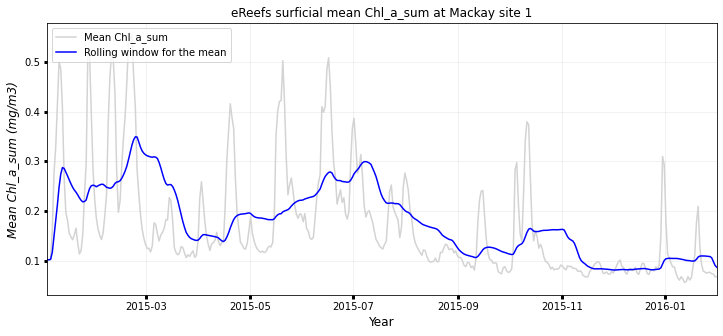

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.Chl_a_sum_1, color="lightgrey", label="Mean Chl_a_sum")
ax1.plot(
    timeseries.date,
    timeseries.Chl_a_sum_roll_1,
    color="blue",
    label="Rolling window for the mean",
)
ax1.legend(
    labels=["Mean Chl_a_sum", "Rolling window for the mean"],
    loc="upper left",
)
ax1.set_ylabel("Mean Chl_a_sum (mg/m3)", style="italic", fontsize=12)
print("Max surface Chl_a_sum: {:0.3f} mg/m3".format(max(timeseries.Chl_a_sum_1)))
print("Mean surface Chl_a_sum: {:0.3f} mg/m3".format(np.mean(timeseries.Chl_a_sum_1)))
print("Median surface Chl_a_sum: {:0.3f} mg/m3".format(np.median(timeseries.Chl_a_sum_1)))
print(
    "95th percentile mean Chl_a_sum: {:0.3f} mg/m3".format(
        np.percentile(timeseries.Chl_a_sum_1, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title('eReefs surficial mean Chl_a_sum at Mackay site 1')
plt.show()
#fig.savefig("DaviesReefcurrentVariability", dpi=100)


From this figure, we think the roll is easier to observe the trend. Therefore, we use the roll of all variables to make line charts.

In [13]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

DIN_roll_1 = rolling["DIN"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "DIN": df['DIN'],
                "DIN_roll_1": DIN_roll_1,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,DIN,DIN_roll_1,day,month,year
0,2015-01-01 12:00:00,0.037532,0.037532,1,1,2015
1,2015-01-02 12:00:00,0.031354,0.034443,2,1,2015
2,2015-01-03 12:00:00,0.031651,0.033512,3,1,2015
3,2015-01-04 12:00:00,0.052138,0.038169,4,1,2015
4,2015-01-05 12:00:00,0.065477,0.043630,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.030217,0.071623,27,1,2016
392,2016-01-28 12:00:00,0.027995,0.071212,28,1,2016
393,2016-01-29 12:00:00,0.033285,0.069060,29,1,2016
394,2016-01-30 12:00:00,0.055227,0.068792,30,1,2016


In [14]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

TSSM_roll_1 = rolling["TSSM"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "TSSM": df['TSSM'],
                "TSSM_roll_1": TSSM_roll_1,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,TSSM,TSSM_roll_1,day,month,year
0,2015-01-01 12:00:00,0.000720,0.000720,1,1,2015
1,2015-01-02 12:00:00,0.000720,0.000720,2,1,2015
2,2015-01-03 12:00:00,0.000848,0.000763,3,1,2015
3,2015-01-04 12:00:00,0.001451,0.000935,4,1,2015
4,2015-01-05 12:00:00,0.001790,0.001106,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.000685,0.000939,27,1,2016
392,2016-01-28 12:00:00,0.000690,0.000872,28,1,2016
393,2016-01-29 12:00:00,0.000681,0.000770,29,1,2016
394,2016-01-30 12:00:00,0.000668,0.000752,30,1,2016


In [15]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

PAR_roll_1 = rolling["PAR"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "PAR": df['PAR'],
                "PAR_roll_1": PAR_roll_1,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,PAR,PAR_roll_1,day,month,year
0,2015-01-01 12:00:00,0.000962,0.000962,1,1,2015
1,2015-01-02 12:00:00,0.000727,0.000844,2,1,2015
2,2015-01-03 12:00:00,0.000477,0.000722,3,1,2015
3,2015-01-04 12:00:00,0.000740,0.000726,4,1,2015
4,2015-01-05 12:00:00,0.000258,0.000633,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.001332,0.001199,27,1,2016
392,2016-01-28 12:00:00,0.000829,0.001217,28,1,2016
393,2016-01-29 12:00:00,0.000914,0.001237,29,1,2016
394,2016-01-30 12:00:00,0.000970,0.001233,30,1,2016


In [16]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

Secchi_roll_1 = rolling["Secchi"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "Secchi": df['Secchi'],
                "Secchi_roll_1": Secchi_roll_1,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,Secchi,Secchi_roll_1,day,month,year
0,2015-01-01 12:00:00,14.272367,14.272367,1,1,2015
1,2015-01-02 12:00:00,15.239410,14.755889,2,1,2015
2,2015-01-03 12:00:00,13.043923,14.185234,3,1,2015
3,2015-01-04 12:00:00,5.045837,11.900384,4,1,2015
4,2015-01-05 12:00:00,4.012533,10.322814,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,15.650508,13.504455,27,1,2016
392,2016-01-28 12:00:00,15.065257,13.926866,28,1,2016
393,2016-01-29 12:00:00,14.480111,14.356822,29,1,2016
394,2016-01-30 12:00:00,14.023984,14.582594,30,1,2016


### Correlation in site 1


In [17]:
Chl_a_sum_PAR = scipy.stats.pearsonr(df['Chl_a_sum'],df['PAR']) 
print('+ Pearson correlation between Chl_a_sum and PAR:',Chl_a_sum_PAR[0],'\n')

Chl_a_sum_Secchi = scipy.stats.pearsonr(df['Chl_a_sum'],df['Secchi']) 
print('+ Pearson correlation between Chl_a_sum and Secchi:',Chl_a_sum_Secchi[0],'\n')

DIN_PAR = scipy.stats.pearsonr(df['DIN'],df['PAR']) 
print('+ Pearson correlation between DIN and PAR:',DIN_PAR[0],'\n')

DIN_Secchi = scipy.stats.pearsonr(df['DIN'],df['Secchi']) 
print('+ Pearson correlation between DIN and Secchi:',DIN_Secchi[0],'\n')

TSSM_PAR = scipy.stats.pearsonr(df['TSSM'],df['PAR']) 
print('+ Pearson correlation between TSSM and PAR:',TSSM_PAR[0],'\n')

TSSM_Secchi = scipy.stats.pearsonr(df['TSSM'],df['Secchi']) 
print('+ Pearson correlation between TSSM and Secchi:',TSSM_Secchi[0],'\n')

+ Pearson correlation between Chl_a_sum and PAR: -0.46136766303434834 

+ Pearson correlation between Chl_a_sum and Secchi: -0.7193638280947546 

+ Pearson correlation between DIN and PAR: -0.28654286701597365 

+ Pearson correlation between DIN and Secchi: -0.4918694906671523 

+ Pearson correlation between TSSM and PAR: -0.44159460580762516 

+ Pearson correlation between TSSM and Secchi: -0.8500780060582153 



## Mackay site 2
We download the data from eReef and change the data format in order to calculate correlation and make line charts.

### Download data

In [ ]:
site_lat = -21.129
site_lon = 149.755

In [ ]:
selectedDepthIndex = 16 # corresponding to -0.5 m

In [ ]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

In [ ]:
 start_date = dt.date(2015, 1, 1)
 end_date = dt.date(2016, 1, 1)
 delta = relativedelta(months=+1)

# # Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
 step = True
 while start_date <= end_date:
    
     # Read individual file from the OpeNDAP server
     netCDF_datestr = str(start_date.year)+'-'+format(start_date.month, '02')
     print('Processing time interval:',netCDF_datestr)
     inputFile = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"+netCDF_datestr+".nc"
     
     start_date += delta    
     nc_data = Dataset(inputFile, 'r')
     ncdata = nc_data.variables
    
     # Get parameters values for each single file
     if step:
         lat = ncdata['latitude'][:].filled(fill_value=0.)
         lon = ncdata['longitude'][:].filled(fill_value=0.)
         times = ncdata['time'][:]
         selectedLatIndex = find_nearest(lat,site_lat)
         selectedLonIndex = find_nearest(lon,site_lon)
         DIN = nc_data.variables['DIN'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         Chl_a_sum = nc_data.variables['Chl_a_sum'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex] 
         PAR = nc_data.variables['PAR'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         TSSM = nc_data.variables['TSSM'][:,selectedLatIndex, selectedLonIndex]
         Secchi =  nc_data.variables['Secchi'][:, selectedLatIndex, selectedLonIndex]
     else:
         days = ncdata['time'][:]
         times = np.hstack((times,days))
         dailyDIN = nc_data.variables['DIN'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         DIN = np.hstack((DIN,dailyDIN))
         dailyChl_a_sum = nc_data.variables['Chl_a_sum'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         Chl_a_sum = np.hstack((Chl_a_sum,dailyChl_a_sum))
         dailyPAR = nc_data.variables['PAR'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         PAR = np.hstack((PAR,dailyPAR))
         dailyTSSM = nc_data.variables['TSSM'][:, selectedLatIndex, selectedLonIndex]
         TSSM = np.hstack((TSSM,dailyTSSM))
         dailySecchi = nc_data.variables['Secchi'][:, selectedLatIndex, selectedLonIndex]
         Secchi = np.hstack((Secchi,dailySecchi))
     step = False


 time = pd.to_datetime(times[:],unit='D',origin=pd.Timestamp('1990-01-01'))

 # Create a pandas dataframe containing the information from all the files
 df = pd.DataFrame(
     data={
         "date": time,
         "DIN": DIN, 
         "Chl_a_sum": Chl_a_sum,
         "PAR": PAR,
         "TSSM": TSSM,
         "Secchi":Secchi
     }
 )

# # Store these informations on a file in case you want to reuse them later on without having to 
# # rerun this cell...
 df.to_csv(
         "Mackay_site2_timeseries.csv",
         columns=["date", 
                  "DIN", 
                  "Chl_a_sum",
                  "PAR",
                  "TSSM",
                  "Secchi",],
         sep=" ",
         index=False,
         header=1,
     )

### Read data and change format to rolling

In [18]:
df = pd.read_csv(
        "Mackay_site2_timeseries.csv",
        sep=r"\s+",
        engine="c",
        header=0,
        na_filter=False,
        low_memory=False,
    )
df['date']= pd.to_datetime(df['date'])

In [19]:
df

,date,DIN,Chl_a_sum,PAR,TSSM,Secchi
0,2015-01-01 12:00:00,0.167364,0.068781,0.001119,0.000666,20.910997
1,2015-01-02 12:00:00,0.106187,0.101482,0.001411,0.000703,21.453104
2,2015-01-03 12:00:00,0.078398,0.176736,0.000793,0.000783,20.405080
3,2015-01-04 12:00:00,0.110423,0.234887,0.000756,0.000892,16.503763
4,2015-01-05 12:00:00,0.128464,0.273251,0.000604,0.000921,15.484485
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.077524,0.158617,0.001307,0.000818,16.156645
392,2016-01-28 12:00:00,0.075595,0.164038,0.000994,0.000867,16.118212
393,2016-01-29 12:00:00,0.070006,0.162234,0.000947,0.000864,16.305264
394,2016-01-30 12:00:00,0.066384,0.156656,0.001020,0.000839,16.810465


In [20]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

Chl_a_sum_roll_2 = rolling["Chl_a_sum"]
Chl_a_sum_2 = df["Chl_a_sum"]
# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "Chl_a_sum_2": Chl_a_sum_2,
                "Chl_a_sum_roll_2": Chl_a_sum_roll_2,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,Chl_a_sum_2,Chl_a_sum_roll_2,day,month,year
0,2015-01-01 12:00:00,0.068781,0.068781,1,1,2015
1,2015-01-02 12:00:00,0.101482,0.085131,2,1,2015
2,2015-01-03 12:00:00,0.176736,0.115666,3,1,2015
3,2015-01-04 12:00:00,0.234887,0.145471,4,1,2015
4,2015-01-05 12:00:00,0.273251,0.171027,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.158617,0.135622,27,1,2016
392,2016-01-28 12:00:00,0.164038,0.134052,28,1,2016
393,2016-01-29 12:00:00,0.162234,0.133054,29,1,2016
394,2016-01-30 12:00:00,0.156656,0.132236,30,1,2016


In [21]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

DIN_roll_2 = rolling["DIN"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "DIN": df['DIN'],
                "DIN_roll_2": DIN_roll_2,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,DIN,DIN_roll_2,day,month,year
0,2015-01-01 12:00:00,0.167364,0.167364,1,1,2015
1,2015-01-02 12:00:00,0.106187,0.136775,2,1,2015
2,2015-01-03 12:00:00,0.078398,0.117316,3,1,2015
3,2015-01-04 12:00:00,0.110423,0.115593,4,1,2015
4,2015-01-05 12:00:00,0.128464,0.118167,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.077524,0.083164,27,1,2016
392,2016-01-28 12:00:00,0.075595,0.082462,28,1,2016
393,2016-01-29 12:00:00,0.070006,0.081825,29,1,2016
394,2016-01-30 12:00:00,0.066384,0.081311,30,1,2016


In [22]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

TSSM_roll_2 = rolling["TSSM"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "TSSM": df['TSSM'],
                "TSSM_roll_2": TSSM_roll_2,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,TSSM,TSSM_roll_2,day,month,year
0,2015-01-01 12:00:00,0.000666,0.000666,1,1,2015
1,2015-01-02 12:00:00,0.000703,0.000685,2,1,2015
2,2015-01-03 12:00:00,0.000783,0.000718,3,1,2015
3,2015-01-04 12:00:00,0.000892,0.000761,4,1,2015
4,2015-01-05 12:00:00,0.000921,0.000793,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.000818,0.000805,27,1,2016
392,2016-01-28 12:00:00,0.000867,0.000803,28,1,2016
393,2016-01-29 12:00:00,0.000864,0.000800,29,1,2016
394,2016-01-30 12:00:00,0.000839,0.000799,30,1,2016


In [23]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

PAR_roll_2 = rolling["PAR"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "PAR": df['PAR'],
                "PAR_roll_2": PAR_roll_2,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,PAR,PAR_roll_2,day,month,year
0,2015-01-01 12:00:00,0.001119,0.001119,1,1,2015
1,2015-01-02 12:00:00,0.001411,0.001265,2,1,2015
2,2015-01-03 12:00:00,0.000793,0.001108,3,1,2015
3,2015-01-04 12:00:00,0.000756,0.001020,4,1,2015
4,2015-01-05 12:00:00,0.000604,0.000937,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.001307,0.001272,27,1,2016
392,2016-01-28 12:00:00,0.000994,0.001289,28,1,2016
393,2016-01-29 12:00:00,0.000947,0.001298,29,1,2016
394,2016-01-30 12:00:00,0.001020,0.001291,30,1,2016


In [24]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

Secchi_roll_2 = rolling["Secchi"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "Secchi": df['Secchi'],
                "Secchi_roll_2": Secchi_roll_2,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,Secchi,Secchi_roll_2,day,month,year
0,2015-01-01 12:00:00,20.910997,20.910997,1,1,2015
1,2015-01-02 12:00:00,21.453104,21.182050,2,1,2015
2,2015-01-03 12:00:00,20.405080,20.923060,3,1,2015
3,2015-01-04 12:00:00,16.503763,19.818236,4,1,2015
4,2015-01-05 12:00:00,15.484485,18.951486,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,16.156645,17.500707,27,1,2016
392,2016-01-28 12:00:00,16.118212,17.534663,28,1,2016
393,2016-01-29 12:00:00,16.305264,17.582725,29,1,2016
394,2016-01-30 12:00:00,16.810465,17.624655,30,1,2016


### Correlation in site 2

In [25]:
Chl_a_sum_PAR = scipy.stats.pearsonr(df['Chl_a_sum'],df['PAR']) 
print('+ Pearson correlation between Chl_a_sum and PAR:',Chl_a_sum_PAR[0],'\n')

Chl_a_sum_Secchi = scipy.stats.pearsonr(df['Chl_a_sum'],df['Secchi']) 
print('+ Pearson correlation between Chl_a_sum and Secchi:',Chl_a_sum_Secchi[0],'\n')

DIN_PAR = scipy.stats.pearsonr(df['DIN'],df['PAR']) 
print('+ Pearson correlation between DIN and PAR:',DIN_PAR[0],'\n')

DIN_Secchi = scipy.stats.pearsonr(df['DIN'],df['Secchi']) 
print('+ Pearson correlation between DIN and Secchi:',DIN_Secchi[0],'\n')

TSSM_PAR = scipy.stats.pearsonr(df['TSSM'],df['PAR']) 
print('+ Pearson correlation between TSSM and PAR:',TSSM_PAR[0],'\n')

TSSM_Secchi = scipy.stats.pearsonr(df['TSSM'],df['Secchi']) 
print('+ Pearson correlation between TSSM and Secchi:',TSSM_Secchi[0],'\n')

+ Pearson correlation between Chl_a_sum and PAR: -0.6059770369730388 

+ Pearson correlation between Chl_a_sum and Secchi: -0.8286636826740157 

+ Pearson correlation between DIN and PAR: -0.31689624348749995 

+ Pearson correlation between DIN and Secchi: -0.48498142350586365 

+ Pearson correlation between TSSM and PAR: -0.3246893574137211 

+ Pearson correlation between TSSM and Secchi: -0.67969974309433 



## Mackay site 3
We download the data from eReef and change the data format in order to calculate correlation and make line charts.

### Download data

In [ ]:
site_lat = -21.129
site_lon = 151.26

In [ ]:
selectedDepthIndex = 16 # corresponding to -0.5 m

In [ ]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

In [ ]:
 start_date = dt.date(2015, 1, 1)
 end_date = dt.date(2016, 1, 1)
 delta = relativedelta(months=+1)

# # Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
 step = True
 while start_date <= end_date:
    
     # Read individual file from the OpeNDAP server
     netCDF_datestr = str(start_date.year)+'-'+format(start_date.month, '02')
     print('Processing time interval:',netCDF_datestr)
     inputFile = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"+netCDF_datestr+".nc"
     
     start_date += delta    
     nc_data = Dataset(inputFile, 'r')
     ncdata = nc_data.variables
    
     # Get parameters values for each single file
     if step:
         lat = ncdata['latitude'][:].filled(fill_value=0.)
         lon = ncdata['longitude'][:].filled(fill_value=0.)
         times = ncdata['time'][:]
         selectedLatIndex = find_nearest(lat,site_lat)
         selectedLonIndex = find_nearest(lon,site_lon)
         DIN = nc_data.variables['DIN'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         Chl_a_sum = nc_data.variables['Chl_a_sum'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex] 
         PAR = nc_data.variables['PAR'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         TSSM = nc_data.variables['TSSM'][:,selectedLatIndex, selectedLonIndex]
         Secchi =  nc_data.variables['Secchi'][:, selectedLatIndex, selectedLonIndex]
     else:
         days = ncdata['time'][:]
         times = np.hstack((times,days))
         dailyDIN = nc_data.variables['DIN'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         DIN = np.hstack((DIN,dailyDIN))
         dailyChl_a_sum = nc_data.variables['Chl_a_sum'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         Chl_a_sum = np.hstack((Chl_a_sum,dailyChl_a_sum))
         dailyPAR = nc_data.variables['PAR'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
         PAR = np.hstack((PAR,dailyPAR))
         dailyTSSM = nc_data.variables['TSSM'][:, selectedLatIndex, selectedLonIndex]
         TSSM = np.hstack((TSSM,dailyTSSM))
         dailySecchi = nc_data.variables['Secchi'][:, selectedLatIndex, selectedLonIndex]
         Secchi = np.hstack((Secchi,dailySecchi))
     step = False


 time = pd.to_datetime(times[:],unit='D',origin=pd.Timestamp('1990-01-01'))

 # Create a pandas dataframe containing the information from all the files
 df = pd.DataFrame(
     data={
         "date": time,
         "DIN": DIN, 
         "Chl_a_sum": Chl_a_sum,
         "PAR": PAR,
         "TSSM": TSSM,
         "Secchi":Secchi
     }
 )

# # Store these informations on a file in case you want to reuse them later on without having to 
# # rerun this cell...
 df.to_csv(
         "Mackay_site3_timeseries.csv",
         columns=["date", 
                  "DIN", 
                  "Chl_a_sum",
                  "PAR",
                  "TSSM",
                  "Secchi",],
         sep=" ",
         index=False,
         header=1,
     )

### Read data and change format to rolling

In [26]:
df = pd.read_csv(
        "Mackay_site3_timeseries.csv",
        sep=r"\s+",
        engine="c",
        header=0,
        na_filter=False,
        low_memory=False,
    )
df['date']= pd.to_datetime(df['date'])

In [27]:
df

,date,DIN,Chl_a_sum,PAR,TSSM,Secchi
0,2015-01-01 12:00:00,0.569937,0.456722,0.001090,0.001013,18.002445
1,2015-01-02 12:00:00,0.493516,0.481974,0.000834,0.001034,17.799643
2,2015-01-03 12:00:00,0.449912,0.494190,0.001494,0.001073,17.101517
3,2015-01-04 12:00:00,0.348073,0.485338,0.001401,0.001099,16.726698
4,2015-01-05 12:00:00,0.342745,0.511888,0.001340,0.001099,16.708864
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.448788,0.543816,0.001370,0.001068,16.895798
392,2016-01-28 12:00:00,0.462797,0.510415,0.001339,0.001036,17.566435
393,2016-01-29 12:00:00,0.517107,0.499796,0.001105,0.001011,17.928114
394,2016-01-30 12:00:00,0.450023,0.477226,0.000918,0.000996,18.211946


In [28]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

Chl_a_sum_roll_3 = rolling["Chl_a_sum"]
Chl_a_sum_3 = df["Chl_a_sum"]
# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "Chl_a_sum_3": Chl_a_sum_3,
                "Chl_a_sum_roll_3": Chl_a_sum_roll_3,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,Chl_a_sum_3,Chl_a_sum_roll_3,day,month,year
0,2015-01-01 12:00:00,0.456722,0.456722,1,1,2015
1,2015-01-02 12:00:00,0.481974,0.469348,2,1,2015
2,2015-01-03 12:00:00,0.494190,0.477629,3,1,2015
3,2015-01-04 12:00:00,0.485338,0.479556,4,1,2015
4,2015-01-05 12:00:00,0.511888,0.486022,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.543816,0.484184,27,1,2016
392,2016-01-28 12:00:00,0.510415,0.480176,28,1,2016
393,2016-01-29 12:00:00,0.499796,0.479262,29,1,2016
394,2016-01-30 12:00:00,0.477226,0.477284,30,1,2016


In [29]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

DIN_roll_3 = rolling["DIN"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "DIN": df['DIN'],
                "DIN_roll_3": DIN_roll_3,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,DIN,DIN_roll_3,day,month,year
0,2015-01-01 12:00:00,0.569937,0.569937,1,1,2015
1,2015-01-02 12:00:00,0.493516,0.531727,2,1,2015
2,2015-01-03 12:00:00,0.449912,0.504455,3,1,2015
3,2015-01-04 12:00:00,0.348073,0.465360,4,1,2015
4,2015-01-05 12:00:00,0.342745,0.440837,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.448788,0.393079,27,1,2016
392,2016-01-28 12:00:00,0.462797,0.371905,28,1,2016
393,2016-01-29 12:00:00,0.517107,0.348238,29,1,2016
394,2016-01-30 12:00:00,0.450023,0.333224,30,1,2016


In [30]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

TSSM_roll_3 = rolling["TSSM"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "TSSM": df['TSSM'],
                "TSSM_roll_3": TSSM_roll_3,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,TSSM,TSSM_roll_3,day,month,year
0,2015-01-01 12:00:00,0.001013,0.001013,1,1,2015
1,2015-01-02 12:00:00,0.001034,0.001024,2,1,2015
2,2015-01-03 12:00:00,0.001073,0.001040,3,1,2015
3,2015-01-04 12:00:00,0.001099,0.001055,4,1,2015
4,2015-01-05 12:00:00,0.001099,0.001064,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.001068,0.001055,27,1,2016
392,2016-01-28 12:00:00,0.001036,0.001054,28,1,2016
393,2016-01-29 12:00:00,0.001011,0.001054,29,1,2016
394,2016-01-30 12:00:00,0.000996,0.001053,30,1,2016


In [31]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

PAR_roll_3 = rolling["PAR"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "PAR": df['PAR'],
                "PAR_roll_3": PAR_roll_3,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,PAR,PAR_roll_3,day,month,year
0,2015-01-01 12:00:00,0.001090,0.001090,1,1,2015
1,2015-01-02 12:00:00,0.000834,0.000962,2,1,2015
2,2015-01-03 12:00:00,0.001494,0.001139,3,1,2015
3,2015-01-04 12:00:00,0.001401,0.001205,4,1,2015
4,2015-01-05 12:00:00,0.001340,0.001232,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,0.001370,0.001354,27,1,2016
392,2016-01-28 12:00:00,0.001339,0.001382,28,1,2016
393,2016-01-29 12:00:00,0.001105,0.001381,29,1,2016
394,2016-01-30 12:00:00,0.000918,0.001359,30,1,2016


In [32]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

Secchi_roll_3 = rolling["Secchi"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "Secchi": df['Secchi'],
                "Secchi_roll_3": Secchi_roll_3,}
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,Secchi,Secchi_roll_3,day,month,year
0,2015-01-01 12:00:00,18.002445,18.002445,1,1,2015
1,2015-01-02 12:00:00,17.799643,17.901044,2,1,2015
2,2015-01-03 12:00:00,17.101517,17.634535,3,1,2015
3,2015-01-04 12:00:00,16.726698,17.407576,4,1,2015
4,2015-01-05 12:00:00,16.708864,17.267833,5,1,2015
...,...,...,...,...,...,...
391,2016-01-27 12:00:00,16.895798,17.405119,27,1,2016
392,2016-01-28 12:00:00,17.566435,17.447486,28,1,2016
393,2016-01-29 12:00:00,17.928114,17.465833,29,1,2016
394,2016-01-30 12:00:00,18.211946,17.503180,30,1,2016


### Correlation in site 3

In [33]:
Chl_a_sum_PAR = scipy.stats.pearsonr(df['Chl_a_sum'],df['PAR']) 
print('+ Pearson correlation between Chl_a_sum and PAR:',Chl_a_sum_PAR[0],'\n')

Chl_a_sum_Secchi = scipy.stats.pearsonr(df['Chl_a_sum'],df['Secchi']) 
print('+ Pearson correlation between Chl_a_sum and Secchi:',Chl_a_sum_Secchi[0],'\n')

DIN_PAR = scipy.stats.pearsonr(df['DIN'],df['PAR']) 
print('+ Pearson correlation between DIN and PAR:',DIN_PAR[0],'\n')

DIN_Secchi = scipy.stats.pearsonr(df['DIN'],df['Secchi']) 
print('+ Pearson correlation between DIN and Secchi:',DIN_Secchi[0],'\n')

TSSM_PAR = scipy.stats.pearsonr(df['TSSM'],df['PAR']) 
print('+ Pearson correlation between TSSM and PAR:',TSSM_PAR[0],'\n')

TSSM_Secchi = scipy.stats.pearsonr(df['TSSM'],df['Secchi']) 
print('+ Pearson correlation between TSSM and Secchi:',TSSM_Secchi[0],'\n')

+ Pearson correlation between Chl_a_sum and PAR: -0.36634014955072325 

+ Pearson correlation between Chl_a_sum and Secchi: -0.8534498044306491 

+ Pearson correlation between DIN and PAR: -0.46483599769139244 

+ Pearson correlation between DIN and Secchi: -0.29109666020109454 

+ Pearson correlation between TSSM and PAR: -0.1512623696270879 

+ Pearson correlation between TSSM and Secchi: -0.8645598796609348 



### Make line charts and combine the results from three sites

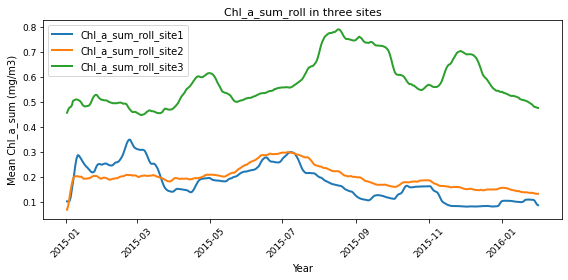

In [47]:
# Make figure
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(timeseries.date, Chl_a_sum_roll_1, linewidth=2, markersize=9, label="Chl_a_sum_roll_site1")
ax.plot(timeseries.date, Chl_a_sum_roll_2, linewidth=2, markersize=9, label="Chl_a_sum_roll_site2")
ax.plot(timeseries.date, Chl_a_sum_roll_3, linewidth=2, markersize=9, label="Chl_a_sum_roll_site3")

ax.set_title("Chl_a_sum_roll in three sites",fontsize=11)
ax.set_ylabel("Mean Chl_a_sum (mg/m3)", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.legend() #loc='upper right', bbox_to_anchor=(0.91, 0.91))
plt.tight_layout()
plt.show()

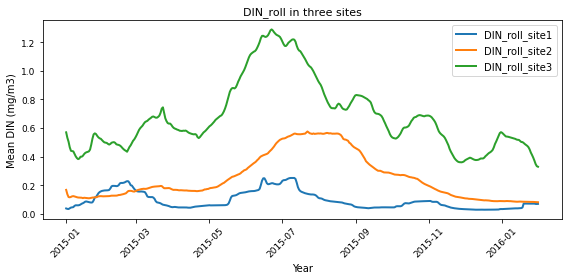

In [48]:
# Make figure
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(timeseries.date, DIN_roll_1, linewidth=2, markersize=9, label="DIN_roll_site1")
ax.plot(timeseries.date, DIN_roll_2, linewidth=2, markersize=9, label="DIN_roll_site2")
ax.plot(timeseries.date, DIN_roll_3, linewidth=2, markersize=9, label="DIN_roll_site3")

ax.set_title("DIN_roll in three sites",fontsize=11)
ax.set_ylabel("Mean DIN (mg/m3)", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.legend() #loc='upper right', bbox_to_anchor=(0.91, 0.91))
plt.tight_layout()
plt.show()

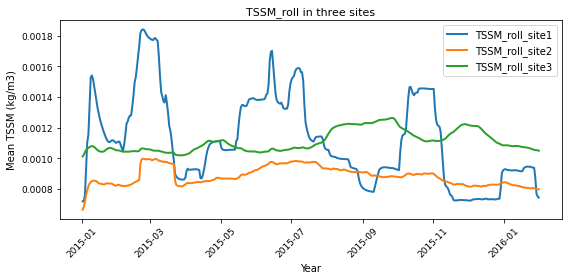

In [49]:
# Make figure
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(timeseries.date, TSSM_roll_1, linewidth=2, markersize=9, label="TSSM_roll_site1")
ax.plot(timeseries.date, TSSM_roll_2, linewidth=2, markersize=9, label="TSSM_roll_site2")
ax.plot(timeseries.date, TSSM_roll_3, linewidth=2, markersize=9, label="TSSM_roll_site3")

ax.set_title("TSSM_roll in three sites",fontsize=11)
ax.set_ylabel("Mean TSSM (kg/m3)", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.legend() #loc='upper right', bbox_to_anchor=(0.91, 0.91))
plt.tight_layout()
plt.show()

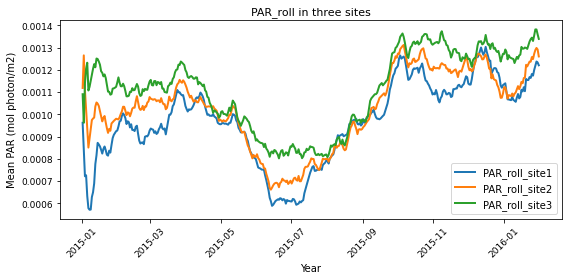

In [50]:
# Make figure
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(timeseries.date, PAR_roll_1, linewidth=2, markersize=9, label="PAR_roll_site1")
ax.plot(timeseries.date, PAR_roll_2, linewidth=2, markersize=9, label="PAR_roll_site2")
ax.plot(timeseries.date, PAR_roll_3, linewidth=2, markersize=9, label="PAR_roll_site3")

ax.set_title("PAR_roll in three sites",fontsize=11)
ax.set_ylabel("Mean PAR (mol photon/m2)", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.legend() #loc='upper right', bbox_to_anchor=(0.91, 0.91))
plt.tight_layout()
plt.show()

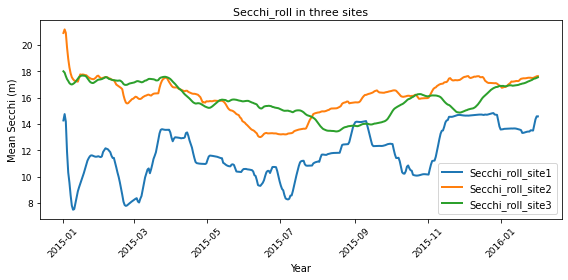

In [51]:
# Make figure
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(timeseries.date, Secchi_roll_1, linewidth=2, markersize=9, label="Secchi_roll_site1")
ax.plot(timeseries.date, Secchi_roll_2, linewidth=2, markersize=9, label="Secchi_roll_site2")
ax.plot(timeseries.date, Secchi_roll_3, linewidth=2, markersize=9, label="Secchi_roll_site3")

ax.set_title("Secchi_roll in three sites",fontsize=11)
ax.set_ylabel("Mean Secchi (m)", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.legend() #loc='upper right', bbox_to_anchor=(0.91, 0.91))
plt.tight_layout()
plt.show()